In [ ]:
# 1
# Bloque de código para extraer e importar los datos desde la API de noticias
# Guardándolos en un archivo CSV

import sys
import os

src_path = os.path.abspath(os.path.join(os.pardir, "src"))
if src_path not in sys.path:
    sys.path.append(src_path)

from app import download_extract_zip_to_csv

# Llamada a la función para descargar y extraer el archivo ZIP desde la API
download_extract_zip_to_csv(output_dir="../data")

Zip file downloaded successfully to: downloaded_data.zip
Extracting CSV files...
Found CSV file: Fake.csv
CSV file saved to: ../data/Fake.csv
Found CSV file: True.csv
CSV file saved to: ../data/True.csv
Deleted the downloaded zip file: downloaded_data.zip


True

## 2

Bloque de código para agregar/extraer nuevas características desde los datos
Considerando que las columnas iniciales son: ['title', 'text', 'subject', 'date']
Se agregarán las siguientes columnas, a través del procesamiento de texto:
 1) ['title_length', 'text_length', 'num_exclamations', 'num_questions',
     'num_uppercase_words', 'num_links', 'num_sentences']
 2) ['subject', 'month', 'weekday', 'title_has_exclamation',
     'title_has_question', 'title_length_cat', 'title_has_link']
 Al final, se guardará el DataFrame en un archivo CSV, y se mostrará la distribución de todas las nuevas
 características generadas.

[nltk_data] Downloading package punkt to /home/cquark/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/cquark/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Fechas no parseadas: 10
['https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/'
 'https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/'
 'https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/'
 'https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg'
 'https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg'
 'MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video]']
Numéricas: 7 ['text_length', 'title_length', 'num_exclamations', 'num_questions', 'num_uppercase_words', 'num_links', 'num_sentences']
Categóricas: 7 ['subject', 'month', 'weekday', 'title_has_exclamation', 'title_has_question', 'title_length_cat', 'title_has_link']
                       count         mean 

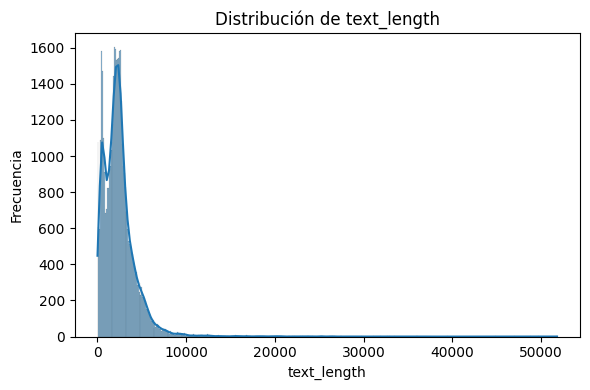

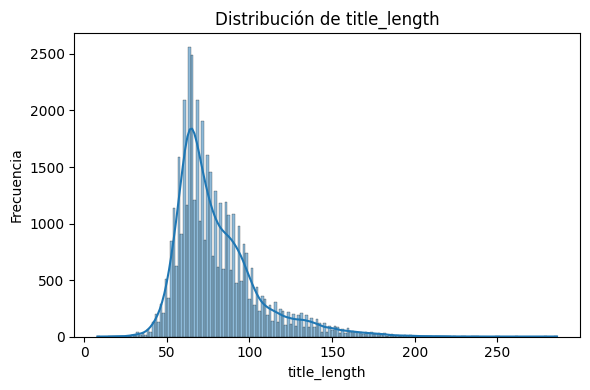

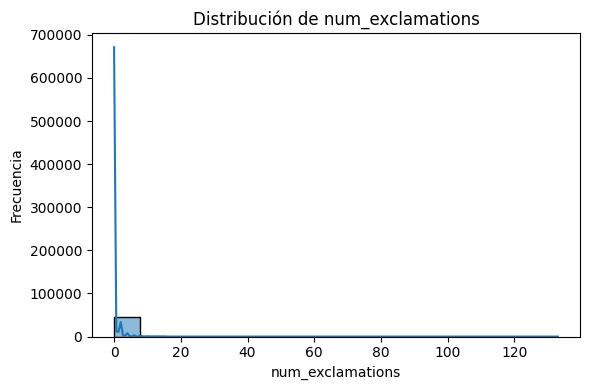

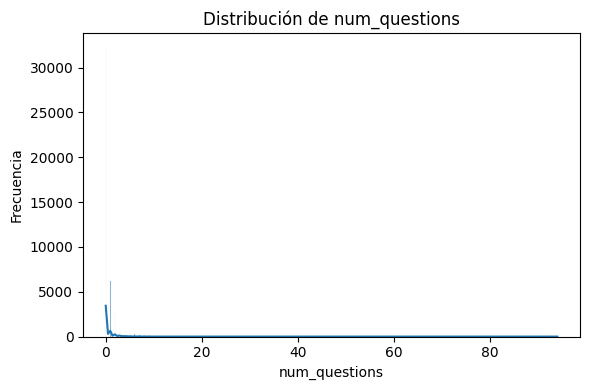

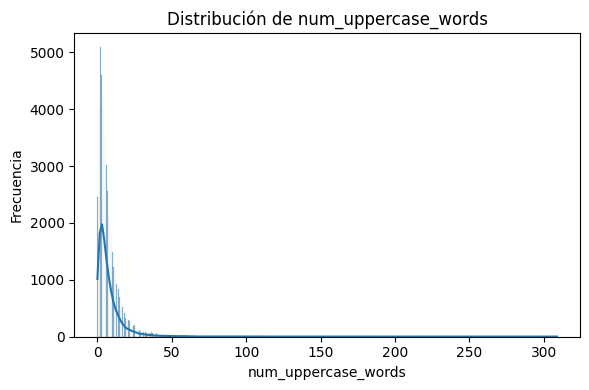

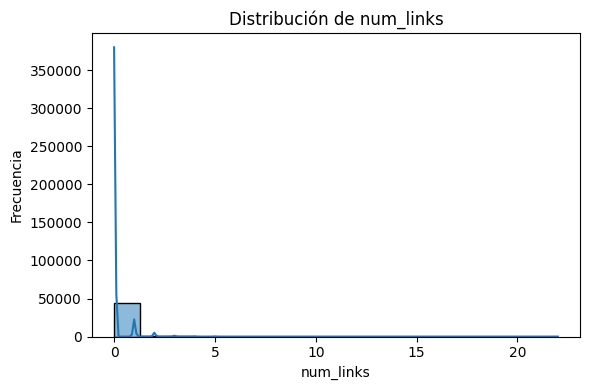

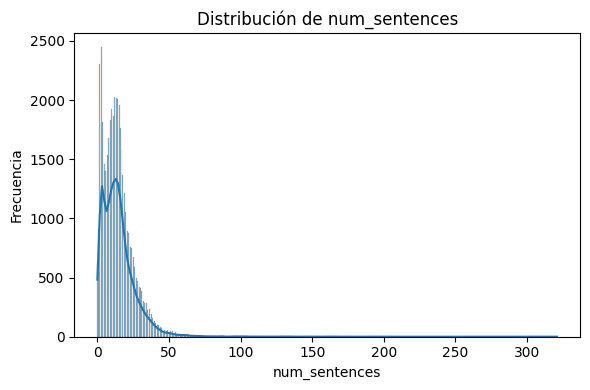


=== Distribución de subject ===


,count,percent
subject,,
politicsNews,11272,25.11
worldnews,10145,22.60
News,9050,20.16
politics,6841,15.24
left-news,4459,9.93
Government News,1570,3.50
US_News,783,1.74
Middle-east,778,1.73


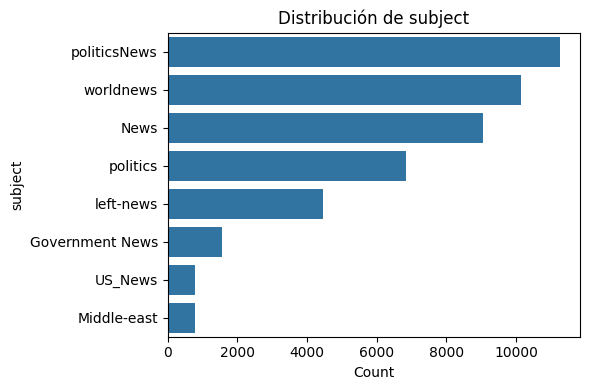


=== Distribución de month ===


,count,percent
month,,
11.0,5536,12.33
10.0,5476,12.20
9.0,5199,11.58
12.0,4614,10.28
3.0,3336,7.43
1.0,3106,6.92
5.0,3076,6.85
4.0,3034,6.76
2.0,2957,6.59


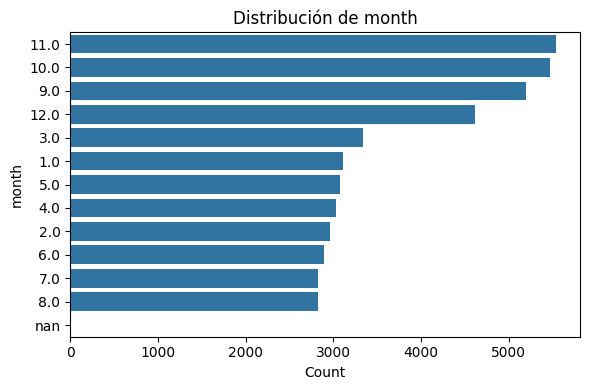


=== Distribución de weekday ===


,count,percent
weekday,,
Wednesday,7741,17.24
Thursday,7690,17.13
Tuesday,7275,16.20
Friday,7174,15.98
Monday,6373,14.19
Sunday,4495,10.01
Saturday,4140,9.22
NaN,10,0.02


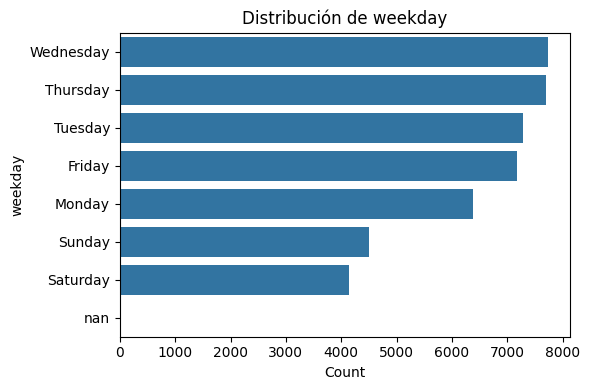


=== Distribución de title_has_exclamation ===


,count,percent
title_has_exclamation,,
no,41608,92.67
yes,3290,7.33


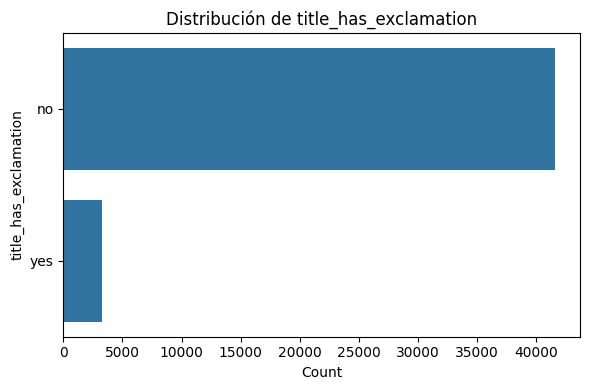


=== Distribución de title_has_question ===


,count,percent
title_has_question,,
no,43118,96.04
yes,1780,3.96


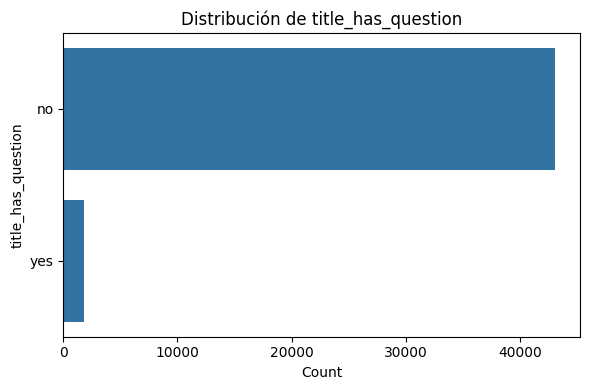


=== Distribución de title_length_cat ===


,count,percent
title_length_cat,,
long,25094,55.89
medium,19762,44.02
short,42,0.09


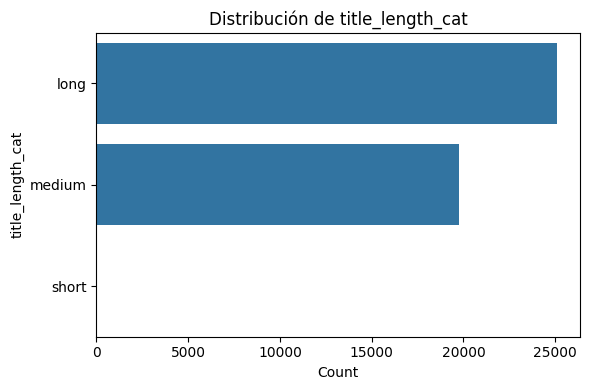


=== Distribución de title_has_link ===


,count,percent
title_has_link,,
no,44889,99.98
yes,9,0.02


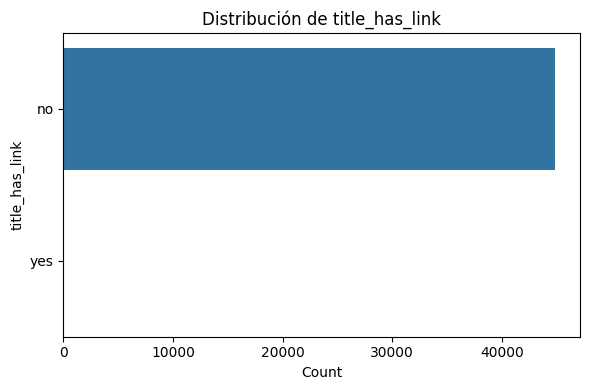

In [ ]:
import pandas as pd
import nltk
import numpy as np
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('punkt_tab')

df_fake = pd.read_csv('../data/Fake.csv')
df_real = pd.read_csv('../data/True.csv')
df = pd.concat([df_fake, df_real], ignore_index=True)
# Asigna el valor 1 a las filas que provienen de df_fake y 0 a las que provienen de df_real.
df['label'] = df.index.map(lambda i: 1 if i < len(df_fake) else 0)

# 2) Numéricas (7)
df['text_length']           = df['text'].apply(len)
df['title_length']          = df['title'].apply(len)
df['num_exclamations']      = df['text'].str.count('!')
df['num_questions']         = df['text'].str.count('\?')
df['num_uppercase_words']   = df['text'].apply(lambda t: sum(1 for w in t.split() if w.isupper()))
df['num_links']             = df['text'].str.count('http')
df['num_sentences']         = df['text'].apply(lambda t: len(sent_tokenize(t)))

# 3) Categóricas (7)
df['subject'] = df['subject'].astype('category')

df['orig_date'] = df['date'].astype(str)

formats = [
    '%b %d, %Y',   # “Apr 1, 2015”
    '%B %d, %Y',  # “April 1, 2015”
    '%d %b %Y',   # “01 Apr 2015”
    '%d %B %Y',   # “01 April 2015”
    '%d-%b-%y',    # “19-Feb-18”
]

def try_parse(x):
    for fmt in formats:
        try:
            return pd.to_datetime(x, format=fmt)
        except (ValueError, TypeError):
            continue
    return pd.NaT

df['date_parsed'] = df['orig_date'].str.strip().apply(try_parse)
df['month']   = df['date_parsed'].dt.month.astype('category')
df['weekday'] = df['date_parsed'].dt.day_name().astype('category')

print("Fechas no parseadas:", df['date_parsed'].isna().sum())
print(df.loc[df['date_parsed'].isna(), 'orig_date'].unique()[:10])

# 3.4 ¿Contiene exclamación en el título?
df['title_has_exclamation'] = (df['title'].str.contains('!')).map({False:'no', True:'yes'}).astype('category')

# 3.5 ¿Contiene pregunta en el título?
df['title_has_question'] = (df['title'].str.contains('\?')).map({False:'no', True:'yes'}).astype('category')

# 3.6 Longitud del título en bins (corto/mediano/largo)
bins = [0, 30, 70, np.inf]
labels = ['short','medium','long']
df['title_length_cat'] = pd.cut(df['title_length'], bins=bins, labels=labels).astype('category')

# 3.7 ¿Hay enlaces en el título?
df['title_has_link'] = (df['title'].str.contains('http')).map({False:'no', True:'yes'}).astype('category')

# 4) Vista rápida
num_cols = ['text_length','title_length','num_exclamations','num_questions',
            'num_uppercase_words','num_links','num_sentences']
cat_cols = ['subject','month','weekday','title_has_exclamation',
            'title_has_question','title_length_cat','title_has_link']

# Conteo de total de columnas 
print("Numéricas:", len(num_cols), num_cols)
print("Categóricas:", len(cat_cols), cat_cols)

print(df[num_cols].describe().T)

# 2) Histogramas para cada variable numérica
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

# 3) Conteo y porcentaje para cada variable categórica
for col in cat_cols:
    vc = df[col].value_counts(dropna=False)
    pct = df[col].value_counts(normalize=True, dropna=False) * 100
    dist = pd.DataFrame({'count': vc, 'percent': pct.round(2)})
    print(f"\n=== Distribución de {col} ===")
    display(dist)

    # Gráfico de barras
    plt.figure(figsize=(6,4))
    sns.countplot(y=col, data=df, order=vc.index)
    plt.title(f'Distribución de {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# Guardar el nuevo DataFrame en un archivo CSV
df.to_csv('../data/processed_data.csv', index=False)

# 3
Bloque de código para el análisis y limpieza de datos faltantes/nulos
A modo de reducir el ruido de datos que introduzcan valores no válidos

In [ ]:
import pandas as pd

df = pd.read_csv('../data/processed_data.csv')
null_counts = df.isnull().sum()
null_percent = (null_counts / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'null_count': null_counts,
    'null_percent': null_percent
}).sort_values(by='null_percent', ascending=False)

print(missing_df)

old_length = len(df)

# Eliminar filas con valores nulos o faltantes
df = df.dropna(axis=0, how='any')

# Mostrar el número de filas eliminadas y las filas restantes
print("Filas eliminadas:", old_length - len(df))
print("Filas restantes:", len(df))


                       null_count  null_percent
weekday                        10          0.02
date_parsed                    10          0.02
month                          10          0.02
title                           0          0.00
date                            0          0.00
subject                         0          0.00
text                            0          0.00
label                           0          0.00
num_questions                   0          0.00
text_length                     0          0.00
title_length                    0          0.00
num_exclamations                0          0.00
num_sentences                   0          0.00
num_links                       0          0.00
num_uppercase_words             0          0.00
orig_date                       0          0.00
title_has_exclamation           0          0.00
title_has_question              0          0.00
title_length_cat                0          0.00
title_has_link                  0       

# 4
Bloque de código para el encodeo de variables categóricas con OneHotEncoder
Las variables a codificar son:
['subject','month','weekday','title_has_exclamation',
'title_has_question','title_length_cat','title_has_link']
Se codificarán como 0s y 1s.

# ¿Por qué se hace esto?
Las variables categóricas se convierten en variables dummy (0s y 1s) para que los modelos de ML puedan interpretarlas sin mayores problemas y sin causar ruido.
Se eliminará la primera categoría de cada variable para evitar la multicolinealidad, que puede causar problemas en los modelos de regresión y otros modelos lineales.

Shape de X: (44888, 35)
Primeras 5 filas del DataFrame codificado (X):
   text_length  title_length  num_exclamations  num_questions  \
0         2893            79                 6              9   
1         1898            69                 0              0   
2         3597            90                 2              4   
3         2774            78                 0              1   
4         2346            70                 0              0   

   num_uppercase_words  num_links  num_sentences  subject_Middle-east  \
0                    5          0             28                  0.0   
1                    3          0             11                  0.0   
2                   42          1             25                  0.0   
3                    5          4             15                  0.0   
4                    0          0             19                  0.0   

   subject_News  subject_US_News  ...  weekday_Monday  weekday_Saturday  \
0           1.0         

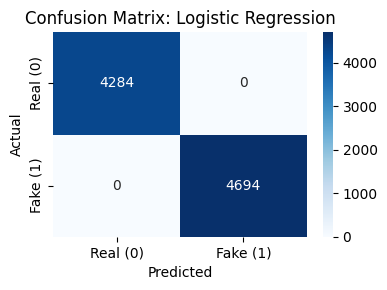


================== Random Forest ==================
=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4284
           1       1.00      1.00      1.00      4694

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978

AUC-ROC: 1.000
=== Confusion Matrix ===
[[4284    0]
 [   0 4694]]


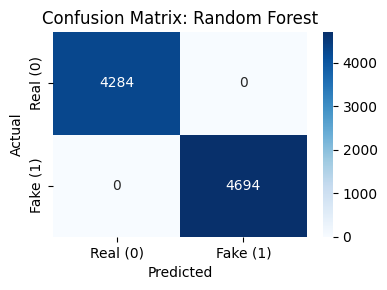


================== SVM ==================
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.75      0.94      0.83      4284
           1       0.92      0.71      0.80      4694

    accuracy                           0.82      8978
   macro avg       0.83      0.82      0.82      8978
weighted avg       0.84      0.82      0.82      8978

AUC-ROC: 0.890
=== Confusion Matrix ===
[[4007  277]
 [1362 3332]]


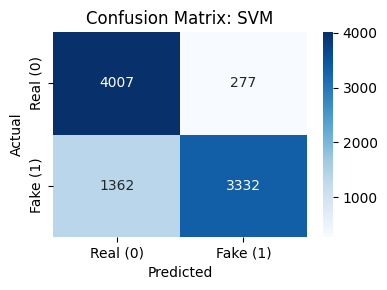

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 1. Carga de datos
df = pd.read_csv('../data/processed_data.csv')
df = df.dropna(axis=0, how='any')

# 2. Columnas categóricas a codificar
cat_cols = [
    'subject','month','weekday',
    'title_has_exclamation','title_has_question',
    'title_length_cat','title_has_link'
]

# 3. Cargar el encoder OneHotEncoder
ohe = OneHotEncoder(
    sparse_output=False,  
    drop='first',
    handle_unknown='ignore'
)


# 4. Aplicar el encoder a las columnas categóricas
#    y concatenar con las columnas numéricas
X_cat_ohe = ohe.fit_transform(df[cat_cols])
ohe_cols = ohe.get_feature_names_out(cat_cols)

X_cat_ohe = pd.DataFrame(X_cat_ohe, columns=ohe_cols, index=df.index)
num_cols = [
    'text_length','title_length','num_exclamations','num_questions',
    'num_uppercase_words','num_links','num_sentences'
]
X = pd.concat([df[num_cols], X_cat_ohe], axis=1)
y = df['label']


print("Shape de X:", X.shape)
print("Primeras 5 filas del DataFrame codificado (X):")
print(X.head())

# Correlación entre variables y variable objetivo (label)
corr = pd.concat([X, y.rename('label')], axis=1).corr()['label'].abs().sort_values(ascending=False)
print(corr.head(20))


# 5
Bloque de experimento con modelos de clasificación
Modelos: Regresión Logística, Random Forest y SVM, según lo solicitado

# División de datos
80% entrenamiento, 20% prueba, estratificado
¿Por qué 80/20?
Para entrenar el modelo con la mayoría de los datos y probarlo con una parte no vista.
Esta proporción es común en la práctica de ML.	
¿Por qué estratificado?
#ara asegurar que la proporción de clases (0s y 1s) sea la misma en ambos conjuntos.


================== Logistic Regression ==================
=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4284
           1       1.00      1.00      1.00      4694

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978

AUC-ROC: 1.000
=== Confusion Matrix ===
[[4284    0]
 [   0 4694]]


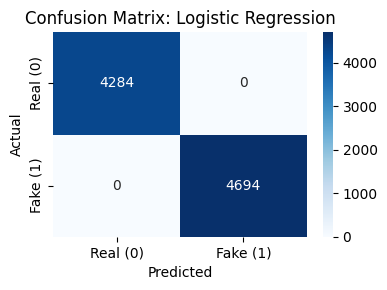


================== Random Forest ==================
=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4284
           1       1.00      1.00      1.00      4694

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978

AUC-ROC: 1.000
=== Confusion Matrix ===
[[4284    0]
 [   0 4694]]


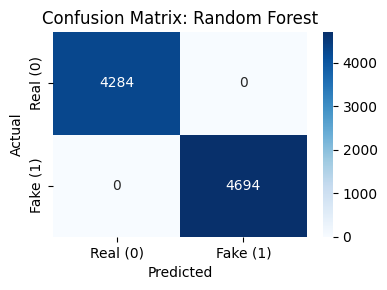


================== SVM ==================
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.75      0.94      0.83      4284
           1       0.92      0.71      0.80      4694

    accuracy                           0.82      8978
   macro avg       0.83      0.82      0.82      8978
weighted avg       0.84      0.82      0.82      8978

AUC-ROC: 0.890
=== Confusion Matrix ===
[[4007  277]
 [1362 3332]]


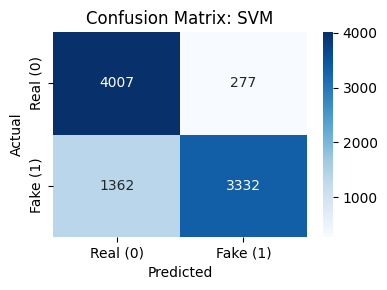

In [ ]:
# 5
# Bloque de experimento con modelos de clasificación
# Modelos: Regresión Logística, Random Forest y SVM, según lo solicitado
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# División de datos
# 80% entrenamiento, 20% prueba, estratificado
# ¿Por qué 80/20?
# Para entrenar el modelo con la mayoría de los datos y probarlo con una parte no vista.
# Esta proporción es común en la práctica de ML.	
# ¿Por qué estratificado?
# Para asegurar que la proporción de clases (0s y 1s) sea la misma en ambos conjuntos.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Diccionario para modelos
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    'SVM': SVC(class_weight='balanced', kernel='rbf', probability=True, random_state=42)
}

results = {}

# Iterar sobre los modelos
# Entrenar y evaluar cada modelo
# Mostrar el reporte de clasificación, AUC-ROC y matriz de confusión
for name, model in models.items():
    print(f"\n================== {name} ==================")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'report': report,
        'auc': auc,
        'cm': cm
    }

    print("=== Classification Report ===")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {auc:.3f}")
    print("=== Confusion Matrix ===")
    print(cm)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real (0)', 'Fake (1)'],
                yticklabels=['Real (0)', 'Fake (1)'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


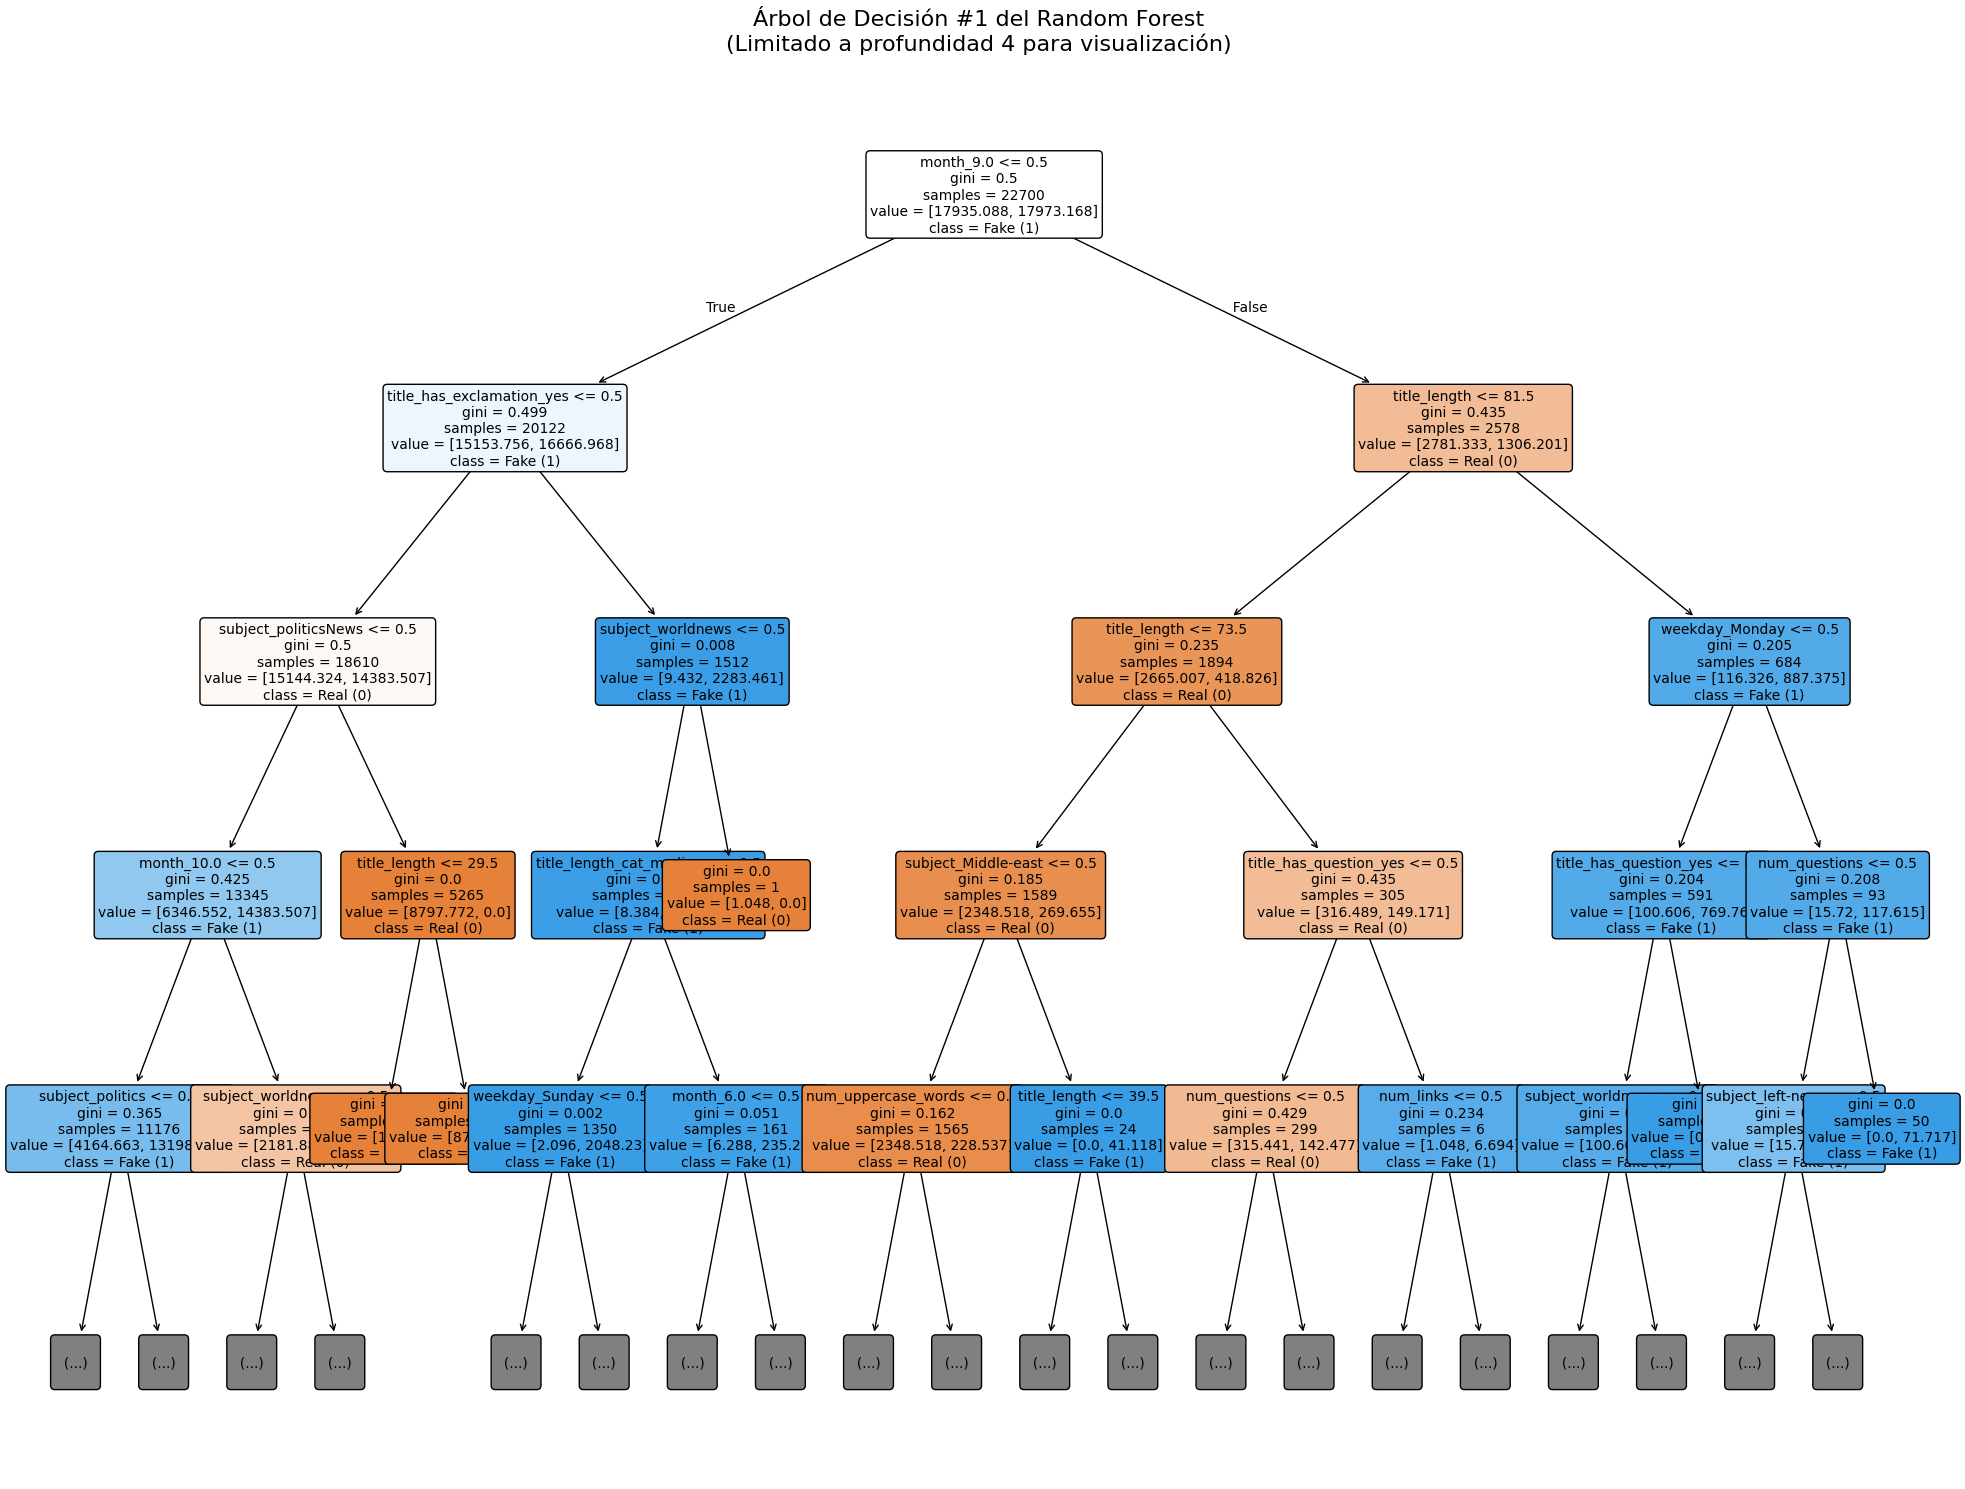

REPRESENTACIÓN TEXTUAL DEL ÁRBOL DE DECISIÓN
|--- month_9.0 <= 0.50
|   |--- title_has_exclamation_yes <= 0.50
|   |   |--- subject_politicsNews <= 0.50
|   |   |   |--- month_10.0 <= 0.50
|   |   |   |   |--- subject_politics <= 0.50
|   |   |   |   |   |--- subject_News <= 0.50
|   |   |   |   |   |   |--- truncated branch of depth 22
|   |   |   |   |   |--- subject_News >  0.50
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- subject_politics >  0.50
|   |   |   |   |   |--- month_2.0 <= 0.50
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- month_2.0 >  0.50
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |--- month_10.0 >  0.50
|   |   |   |   |--- subject_worldnews <= 0.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- subject_worldnews >  0.50
|   |   |   |   |   |--- weekday_Monday <= 0.50
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- weekday_Monday >  0.50
|   |   |   |   |   |   |--- class: 0.0
|   |   |--- subject_

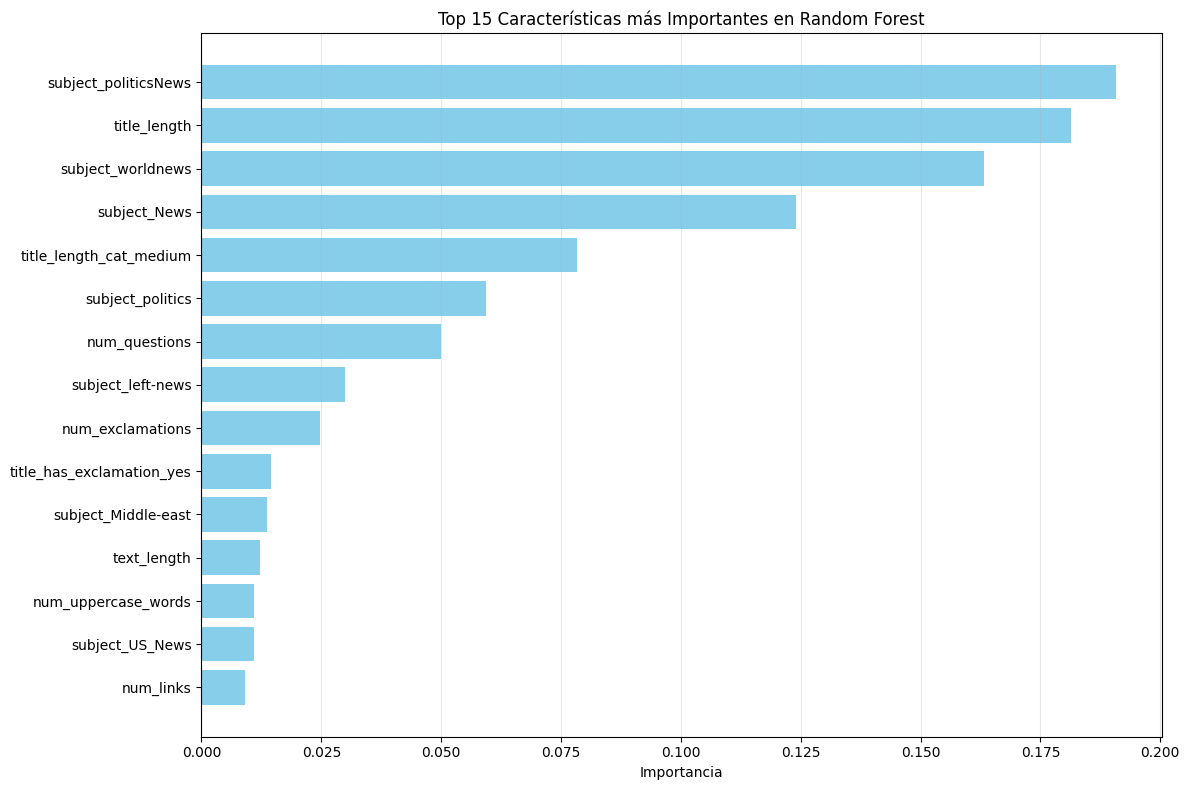


ANÁLISIS DE MÚLTIPLES ÁRBOLES DEL ENSEMBLE

Árbol #1:
  - Profundidad máxima: 27
  - Número de nodos: 469
  - Número de hojas: 235
  - Top 5 características más usadas:
    * title_length: 25 veces
    * subject_worldnews: 24 veces
    * text_length: 20 veces
    * num_sentences: 16 veces
    * num_exclamations: 15 veces

Árbol #2:
  - Profundidad máxima: 26
  - Número de nodos: 615
  - Número de hojas: 308
  - Top 5 características más usadas:
    * text_length: 37 veces
    * num_sentences: 33 veces
    * subject_politicsNews: 29 veces
    * subject_worldnews: 23 veces
    * title_length: 18 veces

Árbol #3:
  - Profundidad máxima: 33
  - Número de nodos: 851
  - Número de hojas: 426
  - Top 5 características más usadas:
    * text_length: 49 veces
    * num_sentences: 46 veces
    * title_length: 41 veces
    * num_uppercase_words: 31 veces
    * subject_politicsNews: 31 veces

ESTADÍSTICAS GENERALES DEL RANDOM FOREST
Número total de árboles: 100
Número de características por árbol

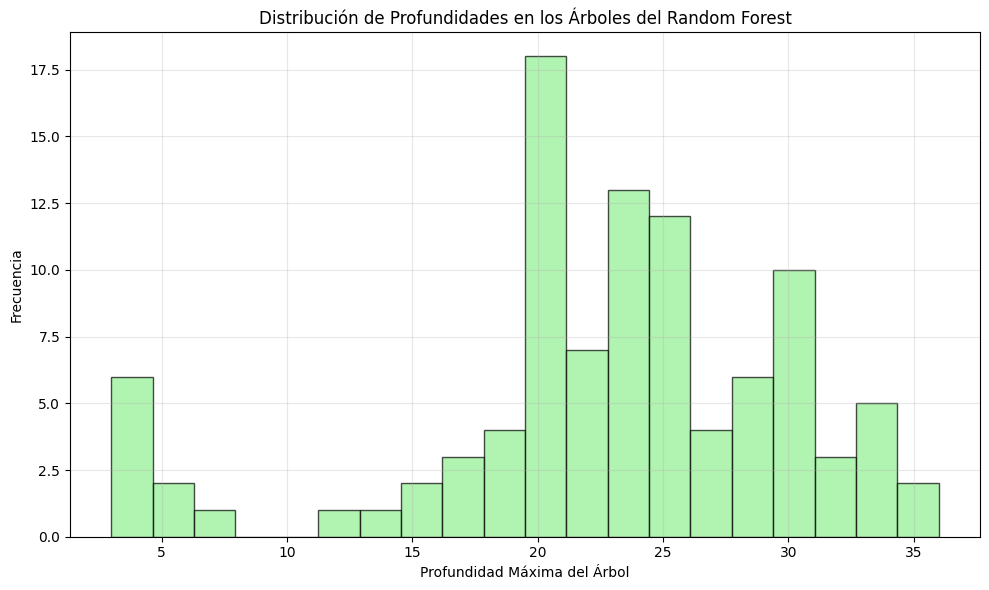


Profundidad promedio de los árboles: 22.80
Profundidad mínima: 3
Profundidad máxima: 36

VISUALIZACIÓN DETALLADA DE ÁRBOLES ESPECÍFICOS
Puedes usar la función visualize_specific_tree(tree_index, max_depth) para ver árboles específicos
Ejemplo: visualize_specific_tree(0, 3) - muestra el primer árbol con profundidad máxima 3


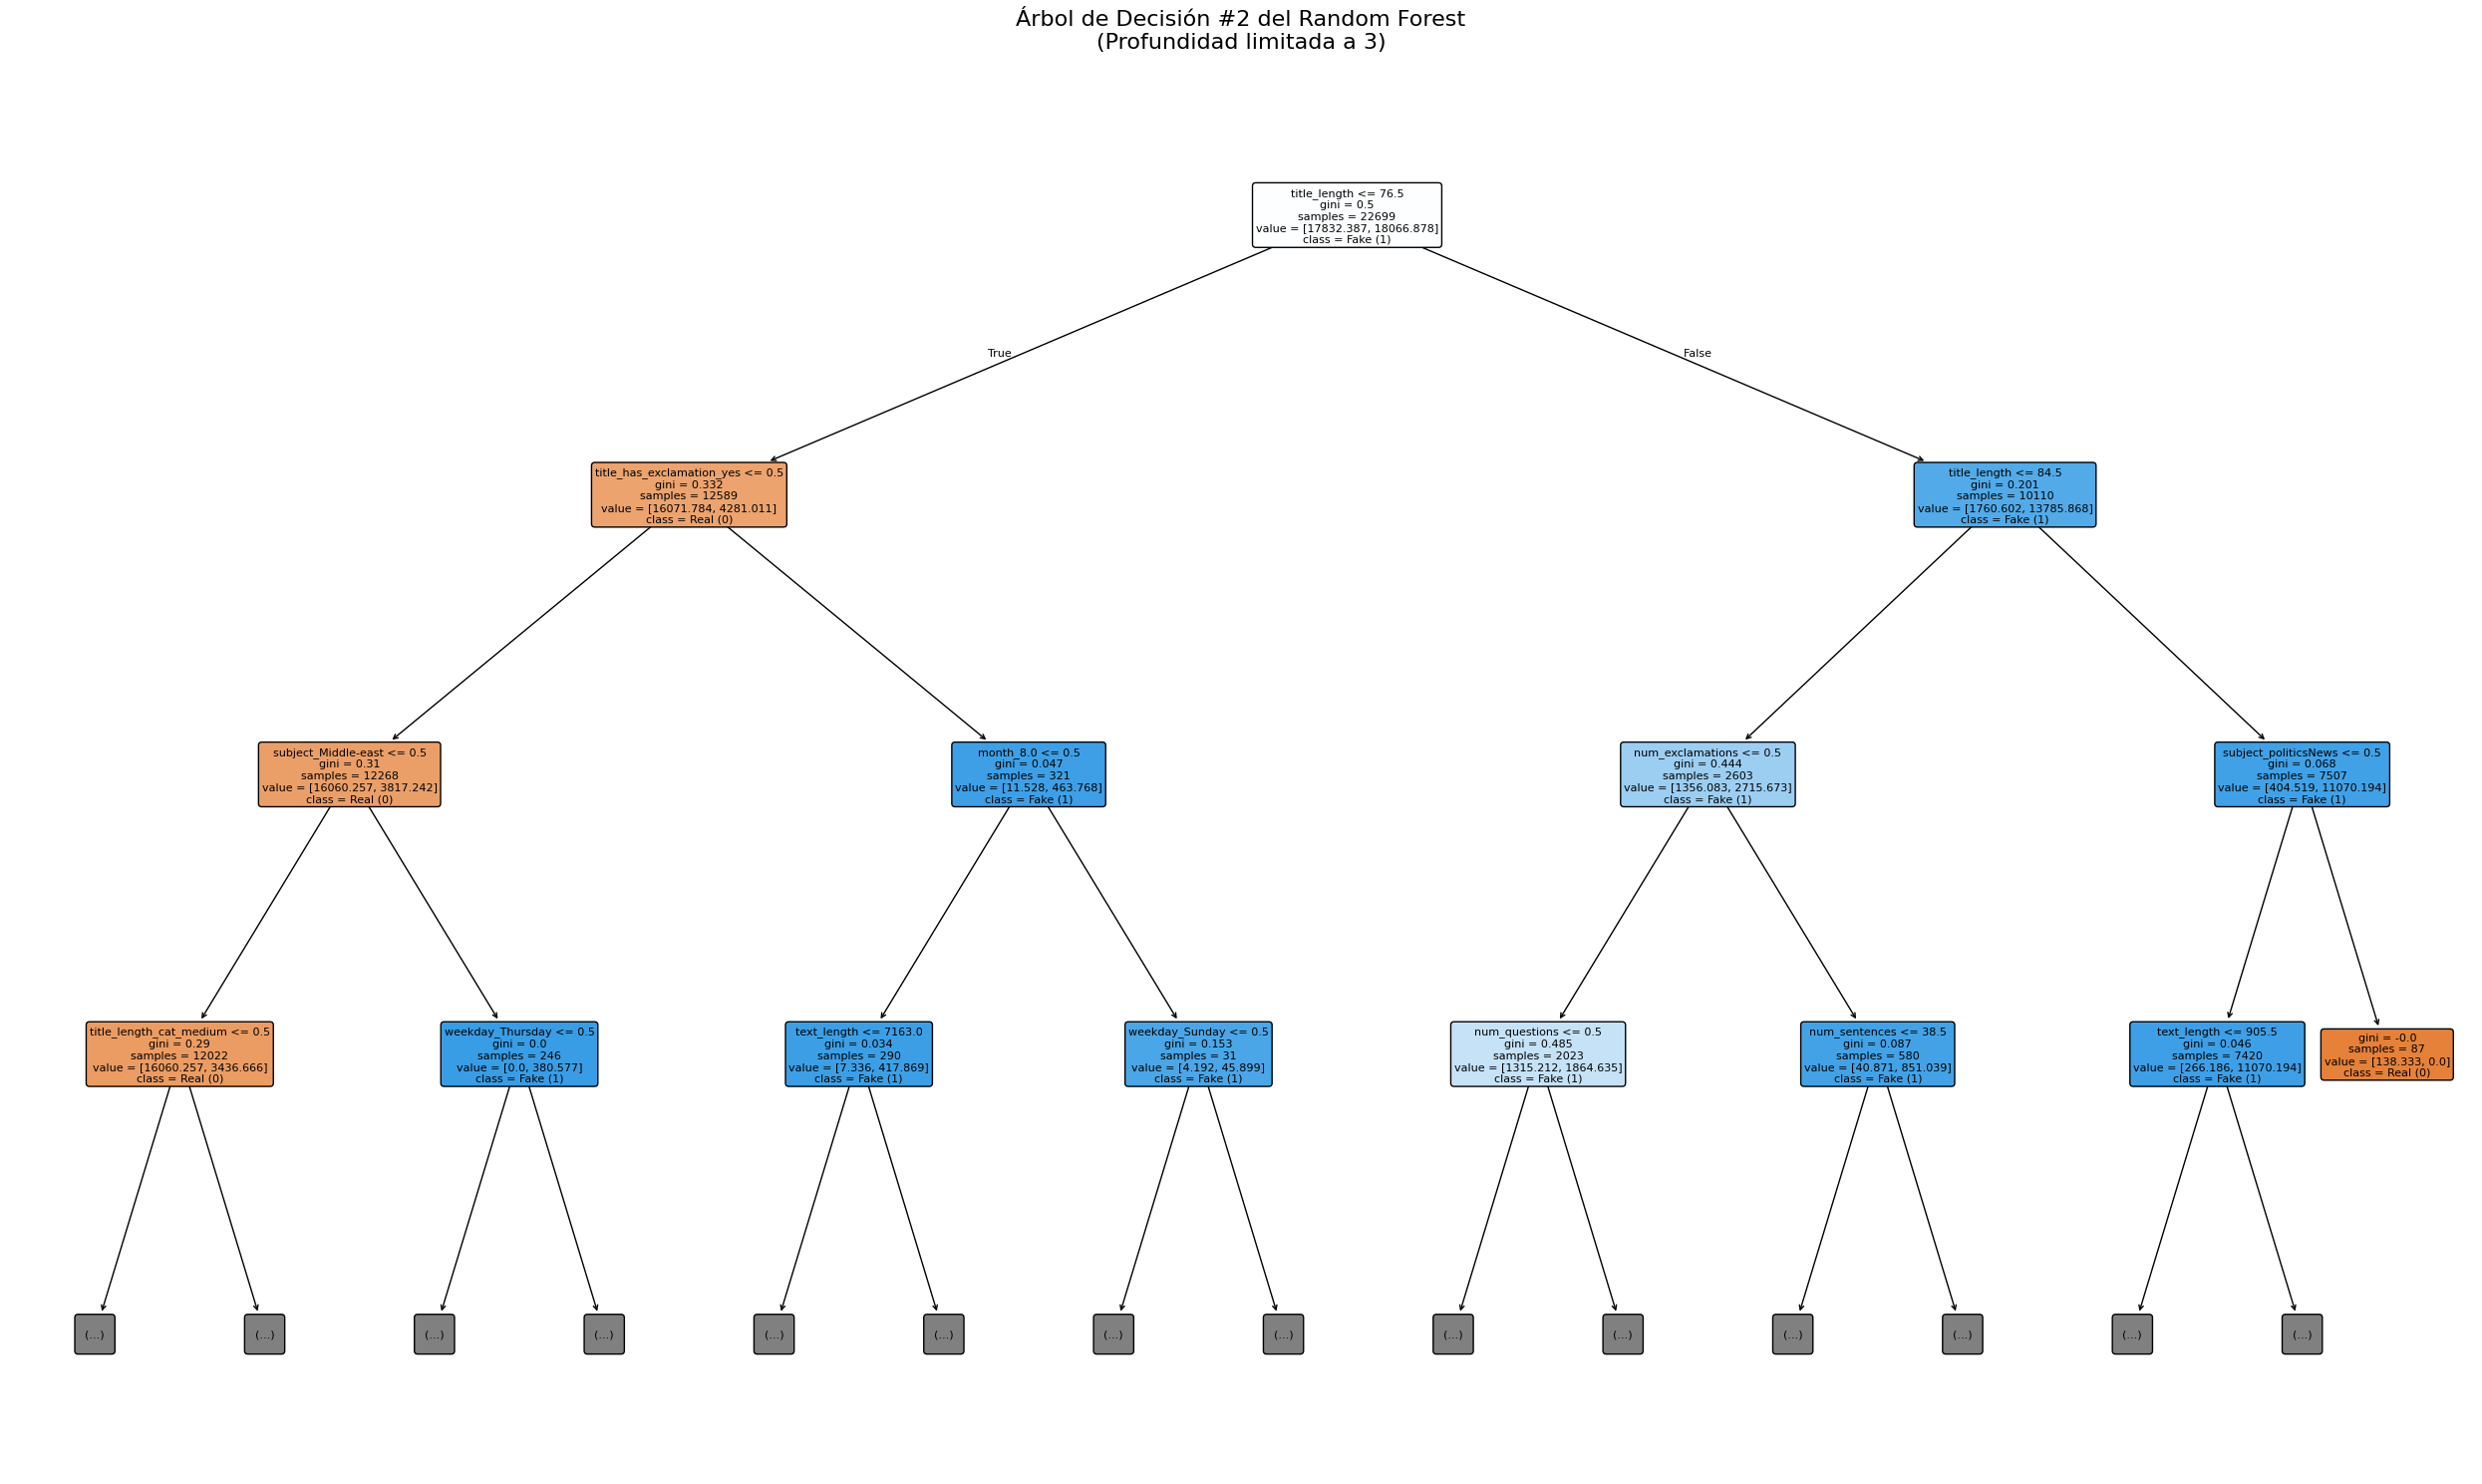

In [ ]:
# 6
# Bloque de visualización del árbol de decisión del Random Forest
# para entender cómo funciona el modelo y que decisiones está tomando
# y sacar algunas conclusiones sobre la importancia de las características
# y también para tratar de entender los valores "perfectos" de los modelos Random Forest y Logistic Regression

# IMPORTANTE:
# Este bloque de código fue generado por Claude Sonnet 4.0, y fue revisado por los participantes de este grupo.

from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt
import numpy as np

# Obtener el modelo Random Forest ya entrenado
rf_model = models['Random Forest']

# ————————————————————————————————————————————————
# 1. VISUALIZACIÓN GRÁFICA DEL ÁRBOL
# ————————————————————————————————————————————————

# Seleccionar el primer árbol del ensemble (o puedes cambiar el índice)
tree_to_visualize = rf_model.estimators_[0]

# Crear la visualización
plt.figure(figsize=(20, 15))
plot_tree(tree_to_visualize, 
          feature_names=X.columns if hasattr(X, 'columns') else [f'Feature_{i}' for i in range(X.shape[1])],
          class_names=['Real (0)', 'Fake (1)'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=4)  # Limitar profundidad para mejor visualización

plt.title('Árbol de Decisión #1 del Random Forest\n(Limitado a profundidad 4 para visualización)', 
          fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# ————————————————————————————————————————————————
# 2. REPRESENTACIÓN TEXTUAL DEL ÁRBOL
# ————————————————————————————————————————————————

print("=" * 80)
print("REPRESENTACIÓN TEXTUAL DEL ÁRBOL DE DECISIÓN")
print("=" * 80)

tree_rules = export_text(tree_to_visualize,
                        feature_names=X.columns if hasattr(X, 'columns') else [f'Feature_{i}' for i in range(X.shape[1])],
                        max_depth=5)  # Limitar profundidad
print(tree_rules)

# ————————————————————————————————————————————————
# 3. ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS
# ————————————————————————————————————————————————

# Obtener importancia de características del Random Forest completo
feature_importance = rf_model.feature_importances_
feature_names = X.columns if hasattr(X, 'columns') else [f'Feature_{i}' for i in range(X.shape[1])]

# Crear DataFrame para mejor visualización
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\n" + "=" * 80)
print("IMPORTANCIA DE CARACTERÍSTICAS EN EL RANDOM FOREST")
print("=" * 80)
print(importance_df.head(15))

# Gráfico de importancia
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importancia')
plt.title('Top 15 Características más Importantes en Random Forest')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ————————————————————————————————————————————————
# 4. COMPARACIÓN ENTRE MÚLTIPLES ÁRBOLES
# ————————————————————————————————————————————————

print("\n" + "=" * 80)
print("ANÁLISIS DE MÚLTIPLES ÁRBOLES DEL ENSEMBLE")
print("=" * 80)

# Analizar los primeros 3 árboles
for i in range(min(3, len(rf_model.estimators_))):
    tree = rf_model.estimators_[i]
    print(f"\nÁrbol #{i+1}:")
    print(f"  - Profundidad máxima: {tree.tree_.max_depth}")
    print(f"  - Número de nodos: {tree.tree_.node_count}")
    print(f"  - Número de hojas: {tree.tree_.n_leaves}")
    
    # Obtener las características más usadas en cada árbol
    feature_usage = np.zeros(len(feature_names))
    for node in range(tree.tree_.node_count):
        if tree.tree_.feature[node] != -2:  # -2 indica nodo hoja
            feature_usage[tree.tree_.feature[node]] += 1
    
    top_features_tree = [(feature_names[i], count) for i, count in enumerate(feature_usage) if count > 0]
    top_features_tree.sort(key=lambda x: x[1], reverse=True)
    
    print(f"  - Top 5 características más usadas:")
    for feat, count in top_features_tree[:5]:
        print(f"    * {feat}: {int(count)} veces")

# ————————————————————————————————————————————————
# 5. ESTADÍSTICAS DEL RANDOM FOREST
# ————————————————————————————————————————————————

print("\n" + "=" * 80)
print("ESTADÍSTICAS GENERALES DEL RANDOM FOREST")
print("=" * 80)

print(f"Número total de árboles: {rf_model.n_estimators}")
print(f"Número de características por árbol: {rf_model.max_features}")
print(f"Profundidad máxima permitida: {rf_model.max_depth}")
print(f"Mínimo de muestras para dividir: {rf_model.min_samples_split}")
print(f"Mínimo de muestras en hoja: {rf_model.min_samples_leaf}")

# Distribución de profundidades de los árboles
depths = [tree.tree_.max_depth for tree in rf_model.estimators_]
plt.figure(figsize=(10, 6))
plt.hist(depths, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Profundidad Máxima del Árbol')
plt.ylabel('Frecuencia')
plt.title('Distribución de Profundidades en los Árboles del Random Forest')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nProfundidad promedio de los árboles: {np.mean(depths):.2f}")
print(f"Profundidad mínima: {np.min(depths)}")
print(f"Profundidad máxima: {np.max(depths)}")

# ————————————————————————————————————————————————
# 6. FUNCIÓN PARA VISUALIZAR ÁRBOL ESPECÍFICO
# ————————————————————————————————————————————————

def visualize_specific_tree(tree_index=0, max_depth=3):
    """
    Función para visualizar un árbol específico del Random Forest
    
    Args:
        tree_index (int): Índice del árbol a visualizar (0 a n_estimators-1)
        max_depth (int): Profundidad máxima para mostrar
    """
    if tree_index >= len(rf_model.estimators_):
        print(f"Error: El índice {tree_index} excede el número de árboles ({len(rf_model.estimators_)})")
        return
    
    tree = rf_model.estimators_[tree_index]
    
    plt.figure(figsize=(25, 15))
    plot_tree(tree,
              feature_names=feature_names,
              class_names=['Real (0)', 'Fake (1)'],
              filled=True,
              rounded=True,
              fontsize=8,
              max_depth=max_depth)
    
    plt.title(f'Árbol de Decisión #{tree_index+1} del Random Forest\n(Profundidad limitada a {max_depth})',
              fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
print("\n" + "=" * 80)
print("VISUALIZACIÓN DETALLADA DE ÁRBOLES ESPECÍFICOS")
print("=" * 80)
print("Puedes usar la función visualize_specific_tree(tree_index, max_depth) para ver árboles específicos")
print("Ejemplo: visualize_specific_tree(0, 3) - muestra el primer árbol con profundidad máxima 3")

# Visualizar el segundo árbol como ejemplo
visualize_specific_tree(1, 3)

# Sumario de Resultado de Experimentos (Random Forest, Logistic Regression)

El resultado del experimento con ambos modelos, como se puede observar, deja bastante que desear.
En primer punto, se visualiza que las métricas generadas por los dos primeros modelos probados, Random Forest y Logistic Regression, dan valores perfectos (1.0), lo que resalta que algo está mal, debido a lo sospechosamente perfecto de los resultados; valores tan perfectos no suelen ocurrir en la vida real.

Esto puede indicar un caso de sobreentrenamiento (overfitting). Es probable que estos modelos hayan memorizado patrones específicos del conjunto de entrenamiento, en lugar de generalizar de forma efectiva a nuevos datos. Esto puede deberse a una mala separación entre el set de entrenamiento y prueba (por ejemplo, si no se mezclaron correctamente, o si hay fuga de datos entre ambos). Además, en datasets textuales, un preprocesamiento insuficiente o excesivo puede hacer que palabras específicas del conjunto de entrenamiento "marquen" con demasiada fuerza ciertas clases, influyendo de forma artificial en los resultados.

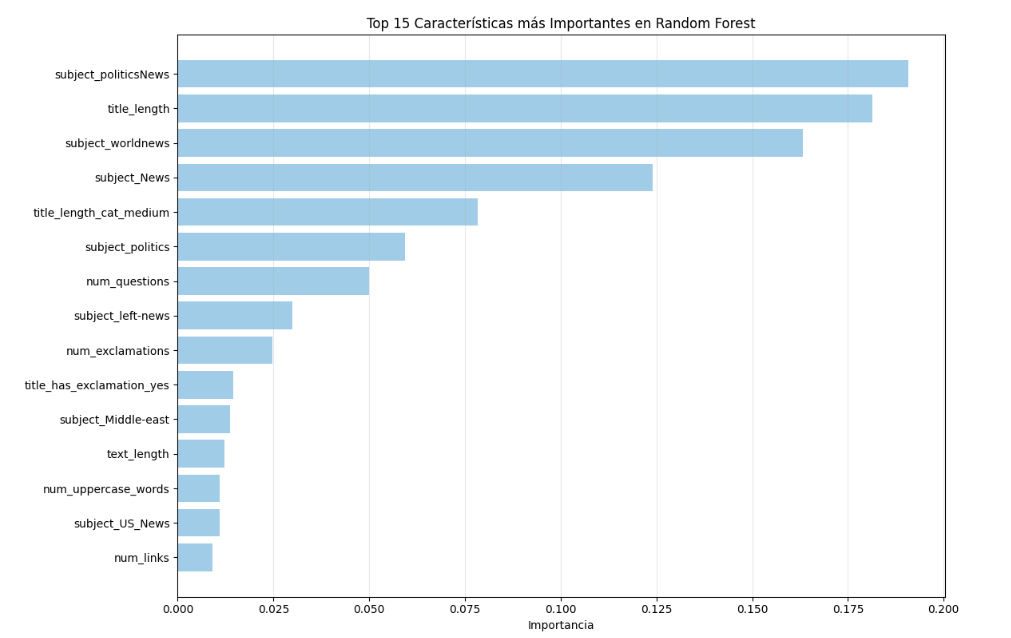

La idea anterior puede reforzarse tras el análisis de importancias de características obtenido del Random Forest. Este análisis muestra que muchas de las variables generadas manualmente —como la longitud del texto, el número de exclamaciones, número de links, la presencia de signos de exclamación o pregunta en el título, etc.— aparecen entre las menos relevantes. Esto indica que el modelo, eventualmente, está absorbiendo el ruido o correlaciones de estas nuevas características para memorizar patrones del conjunto de entrenamiento en lugar de aprender señales generalizables, reforzando así el sobreentrenamiento observado en las métricas de los modelos Random Forest y Logistic Regression. Esto, también, sugiere que la idea de generar nuevas características manualmente a partir del procesamiento de texto, no fue algo provechoso, sino contraproducente.

# Selección de Modelo (SVM)

Un caso distinto sucede al llegar al modelo de Support Vector Machines (SVM). Las métricas resultantes ya no son tan sospechosamente perfectas, y presentan un comportamiento más realista, con una exactitud (accuracy) global del 82 %, y un balance más sensato entre precision y recall para cada clase. Esto sugiere que el modelo SVM está generalizando mejor y que las pruebas se están ejecutando correctamente.

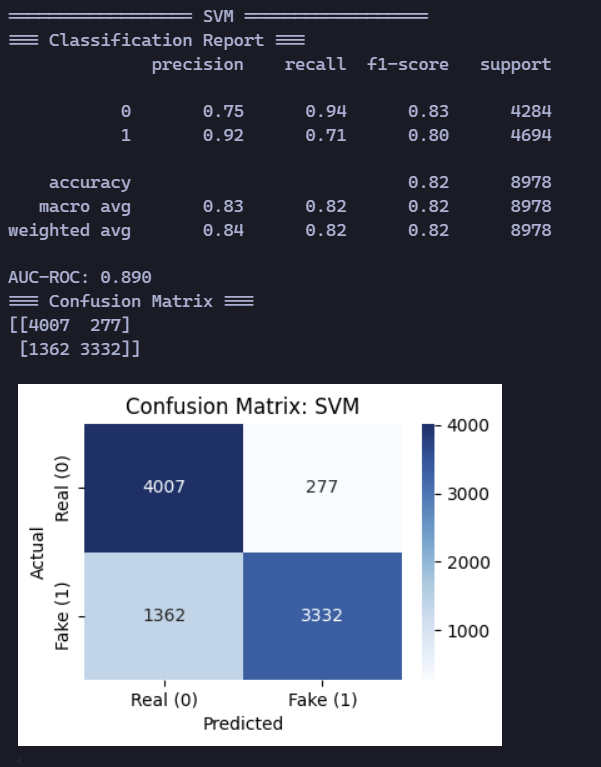

Interpretación de los resultados para el modelo SVM:

Para la clase 0 (noticias reales), se obtuvo un recall de 0.94, lo que significa que el modelo logra identificar correctamente la mayoría de las noticias verdaderas. Sin embargo, su precision de 0.75 indica que también está incluyendo un 25 % de falsas noticias dentro de las predicciones de noticias reales.

Para la clase 1 (noticias falsas), el modelo logra una precision de 0.92, es decir, cuando predice que una noticia es falsa, casi siempre está en lo correcto. No obstante, su recall de 0.71 revela que el modelo deja pasar cerca del 29 % de las noticias falsas sin detectarlas.

El F1-score en ambas clases (0.83 para reales, 0.80 para falsas) indica un buen balance entre precision y recall. La exactitud total (accuracy) de 82 % y los promedios macro y ponderado sugieren un rendimiento general aceptable y equilibrado entre clases.

Se ha seleccionado el SVM debido a que sus métricas globales (accuracy, precision, recall y AUC-ROC) superan a las de Random Forest y Regresión Logística en este experimento. No obstante, este rendimiento superior en los datos de prueba no garantiza que sea la mejor opción definitiva para la clasificación de noticias verdaderas y falsas en producción. Factores como la interpretabilidad, el costo computacional y la robustez frente a cambios de dominio podrían inclinar la balanza hacia otros modelos o enfoques híbridos.

En este contexto, podría evaluarse la posibilidad de:

Ajustar el umbral de decisión para incrementar aún más el recall en la clase 1 (noticias falsas), asumiendo una pequeña pérdida de precision.

Incorporar validación cruzada y pruebas en datos de dominio distinto para validar la estabilidad del SVM.

Evaluar modelos complementarios o ensamblados (por ejemplo, combinar SVM con un clasificador más interpretable) para aprovechar ventajas de cada enfoque.

De esta forma, se garantiza no solo el mejor rendimiento en métricas, sino también la adaptabilidad y confianza necesarias para un sistema de detección de noticias falsas en un ambiente real.